In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# first we create a dataset object of the raw data
from torch.utils.data import Dataset




# ds = PupilDataset('stringer_spontaneous.npy')
# for batch in ds:
#     x, y = batch
# #     break
#
# print(x.shape, x)
# print(y.shape, y)

In [8]:
# Define network architecture. We'll try a simple FF network first.
HP = { 'fc1_in': 11983,
        'fc1_out':2**10 ,
        'fc2_out': 2**8,
        'fc3_out': 2**5,
        'fc4_out': 2**3,
        'fc5_out': 2**0,
       "lr": 1e-3}

class Pnet(nn.Module):
    def __init__(self,  hp):
        super(Pnet, self).__init__()
        self.hp = hp
        self.fc1 = nn.Linear(self.hp['fc1_in'], self.hp['fc3_out'])
        self.fc2 = nn.Linear(self.hp['fc3_out'], self.hp['fc5_out'])
        self.fc3 = nn.Linear(self.hp['fc2_out'], self.hp['fc3_out'])
        self.fc4 = nn.Linear(self.hp['fc3_out'], self.hp['fc4_out'])
        self.fc5 = nn.Linear(self.hp['fc4_out'], self.hp['fc5_out'])
        self.act = nn.Sigmoid()
        self.hidden_layer = None

    def forward(self, x):
        if x.ndim == 1:
            x = self.fc1(x)
            x = self.act(x)
            x = self.fc2(x)
            # x = self.act(x)
            # x = self.fc3(x)
            # x = self.act(x)
            # x = self.fc4(x)
            # x = self.fc5(x)
            return self.act(x)
        else:
            x = x.view(x.shape[0], -1)
            x = self.fc1(x)
            x = self.act(x)
            x = self.fc2(x)
            # x = self.act(x)
            # x = self.fc3(x)
            # x = self.act(x)
            # x = self.fc4(x)
            # x = self.fc5(x)
            return self.act(x)

model = Pnet(HP)
optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'])
test = torch.rand((1, HP['fc1_in']))
model(test)

tensor([[0.5363]], grad_fn=<SigmoidBackward0>)

In [22]:
# @title create training loop with fabric

import lightning as L
from tqdm import tqdm

def validation(model, cost_fn, loader, epoch, num_epochs, batch_size, quiet):
    model.eval()
    running_vloss = 0.0

    with torch.no_grad():
        # p_bar = tqdm(iterable=enumerate(loader), total= len(loader) // batch_size)
        for batch, (vinputs, vlabels) in enumerate(loader):
         vinputs, vlabels = vinputs.float(), vlabels.float()
         voutputs = model(vinputs)
         vcost = cost_fn(voutputs, vlabels)
         running_vloss += vcost.item()

        # if not quiet:
        #     if  batch % 10 == 0:  # Print every 2000 mini-batches
        #         update = f'Epoch {epoch+1}/{num_epochs}, Step {batch}/{len(loader)}, Loss: {vcost.item():.4f}'
        #         p_bar.set_description(update)
        #     p_bar.update()

    return running_vloss

def predict(model, ds, idx:int):
    model.eval()
    test, test_label = ds[idx]
    print(f"label prediction is {model(test).item():.4f} true label is {test_label.item():.4f}")


def train(model, trainloader, valloader, optimizer, cost_fn,  num_epochs= 5 , batch_size:int=32, quiet:bool=True):

    loss = []
    vloss = []
    acc = []
    current_loss = 0
    total_correct = 0
    total_samples = 0

    fabric = L.Fabric()
    fabric.launch
    model, optimizer = fabric.setup(model, optimizer)

    train_loader, val_loader = fabric.setup_dataloaders(trainloader, valloader)


    num_epochs = num_epochs
    for epoch in range(num_epochs):
        model.train()
        # p_bar = tqdm(iterable=enumerate(train_loader), total= len(train_loader)//batch_size)
        for batch, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.float(), labels.float()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # print(outputs.shape)
            # print(labels.shape)
            # outputs = F.softmax(outputs, dim=0).to(torch.float)
            cost = cost_fn(outputs, labels)
            # Backward pass and optimization
            fabric.backward(cost)
            optimizer.step()

            # Print statistics
            current_loss += cost.item()

            # Update the running total of correct predictions and samples
            total_correct += (outputs.detach().numpy() == labels.detach().numpy()).sum().item()
            total_samples += labels.size(0)

            # if quiet:
            #     if  batch % 10 == 0:  # Print every 2000 mini-batches
            #         update = f'Epoch {epoch+1}/{num_epochs}, Step {batch}/{len(train_loader)}, Loss: {cost.item():.4f}'
            #         p_bar.set_description(update)
            #     p_bar.update()

        current_vloss  = validation(model, cost_fn, val_loader, epoch, num_epochs, batch_size, quiet)

        loss.append(current_loss)
        vloss.append(current_vloss)
        acc.append(total_correct/total_samples)
        current_loss = 0

    print('Finished Training')
    return {"loss": loss, "val": vloss, "acc": acc}

In [20]:
    dpath = "face_motion_all.npy"
    lpath = "labels_150Neighors.npy"

    lr = 1e-4
    ds = LayerFaceDataset(dpath, lpath)
    train_loader, val_loader, test_set = split_data(ds, batch_size=64)
    model = PConvNet(HP)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cost_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    history_L2 = train(model, train_loader, val_loader, optimizer, cost_fn, 10, 64)

Finished Training


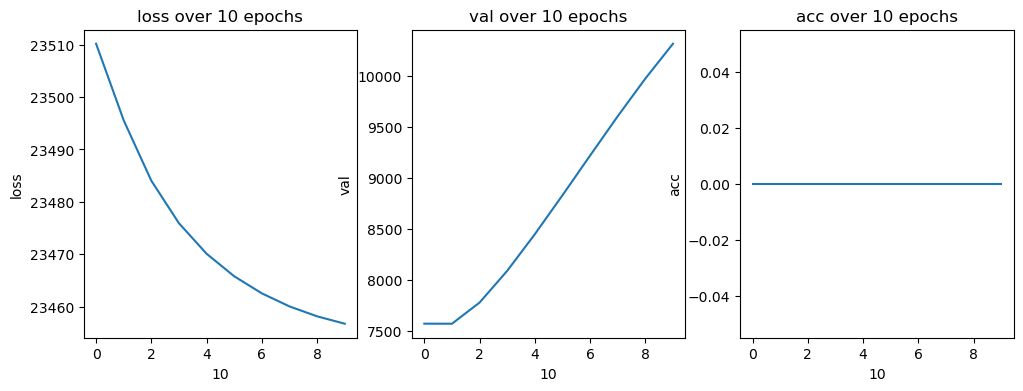

In [21]:
plot_metrics(history_L2)

In [6]:
def plot_metrics(history:dict):
    fig, ax = plt.subplots(nrows=1, ncols=len(history), figsize=(12,4))
    for idx, (key, val) in enumerate(history.items()):
        num_epochs = len(val)
        ax[idx].plot(val)
        ax[idx].set(ylabel=key, xlabel=num_epochs, title=f'{key} over {num_epochs} epochs')
    # plt.close(fig)

In [7]:
import numpy as np
tmp1 = np.random.rand(1,22)
tmp2 = np.random.rand(1,22)
def get_r2(truth, est):
    y = np.asarray(truth)
    ŷ = np.asarray(est)
    rss = np.sum((y - ŷ) **2)
    tss =  np.sum((y - y.mean())**2)
    return  1 - (rss/tss)

r2 = get_r2(tmp1, tmp2)
print(r2)

-0.6686891818003116


In [8]:
def plot_r2(model, test_set,  data:str, λ,  lr):
    truth = list()
    est = list()
    title = f"{data[:-4]} L2 penalty λ={λ:.2E} and lr={lr:.2E}"

    for point, label in test_set:
        point = point.float()
        ŷ = model(point)
        est.append(ŷ.detach().numpy())
        truth.append(label)

    r2 = get_r2(truth, est)
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=200, figsize=(6,6))
    ax.scatter(truth, est)
    xline = plt.xlim()
    yline = plt.ylim()
    ax.text(.01, .92, f'ρ={r2:.2f}', size=20, color='black', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
    ax.plot(xline, yline, color = 'r')
    ax.set(title=title, xlabel="true label", ylabel="estimated label")
    fig.tight_layout()
    fig.savefig(title+".png", bbox_inches='tight')
    plt.close(fig)

In [7]:
fpath = 'stringer_spontaneous.npy'
ds = PupilDataset(fpath)

In [80]:
train_loader, val_loader, test_set = split_data(ds, batch_size=32)
model = Pnet(HP)
optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'])
cost_fn = torch.nn.MSELoss()
history = train(model, train_loader, val_loader, optimizer, cost_fn, 20)

Epoch 1/20, Step 130/132, Loss: 0.0046: : 132it [00:11, 11.29it/s]                 
44it [00:00, 191.07it/s]             
Epoch 2/20, Step 130/132, Loss: 0.0021: : 132it [00:11, 11.36it/s]                 
44it [00:00, 177.03it/s]             
Epoch 3/20, Step 130/132, Loss: 0.0009: : 132it [00:11, 11.28it/s]                 
44it [00:00, 142.43it/s]             
Epoch 4/20, Step 130/132, Loss: 0.0014: : 132it [00:11, 11.42it/s]                 
44it [00:00, 195.99it/s]             
Epoch 5/20, Step 130/132, Loss: 0.0008: : 132it [00:11, 11.74it/s]                 
44it [00:00, 165.47it/s]             
Epoch 6/20, Step 130/132, Loss: 0.0009: : 132it [00:11, 11.85it/s]                 
44it [00:00, 171.16it/s]             
Epoch 7/20, Step 130/132, Loss: 0.0013: : 132it [00:11, 11.67it/s]                 
44it [00:00, 165.50it/s]             
Epoch 8/20, Step 130/132, Loss: 0.0004: : 132it [00:11, 11.86it/s]                 
44it [00:00, 177.87it/s]             
Epoch 9/20, Step 130/132

Finished Training


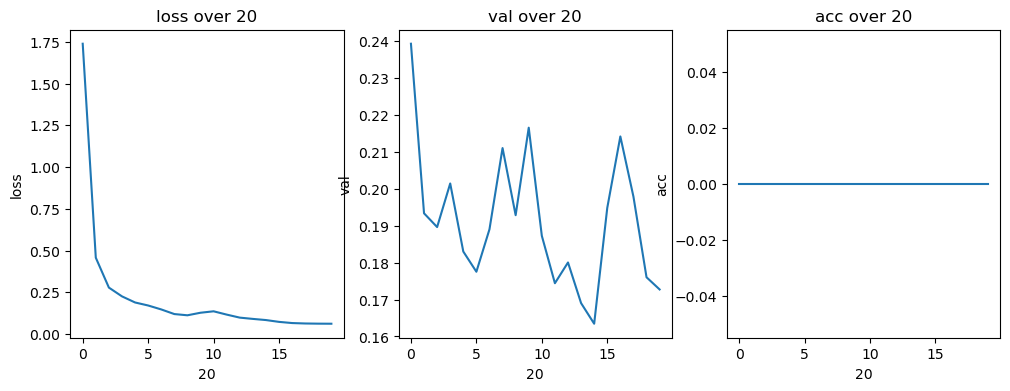

In [81]:
plot_metrics(history)

In [85]:
predict(model,test_set, 4)

label prediction is 0.3073 true label is 0.2920


In [91]:
est = list()
truth = list()
for point, label in test_set:
    ŷ = model(point)
    est.append(ŷ.detach().numpy())
    truth.append(label)


Text(0, 0.5, 'estimated label')

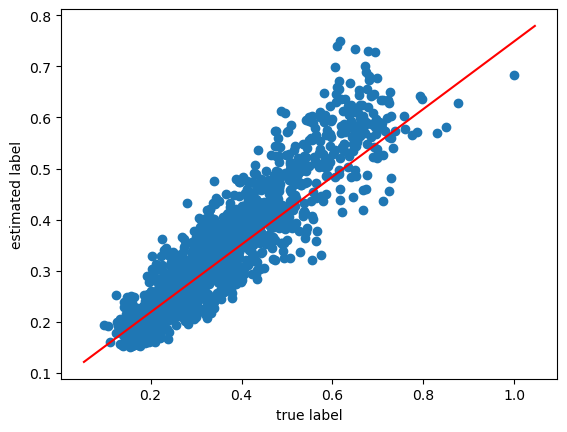

In [99]:
plt.scatter(truth, est)
xline = plt.xlim()
yline = plt.ylim()
plt.plot(xline, yline, color = 'r')
plt.xlabel("true label")
plt.ylabel("estimated label")
plt.title("adam optim")

In [117]:
λ =1e-5
train_loader, val_loader, test_set = split_data(ds, batch_size=32)
model = Pnet(HP)
optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'], weight_decay=1e-5)
cost_fn = torch.nn.MSELoss()
history_L2 = train(model, train_loader, val_loader, optimizer, cost_fn, 20)
plot_metrics(history_L2)

  0%|          | 0/4 [00:00<?, ?it/s]/home/gear/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20, Step 90/132, Loss: 0.0178: : 97it [00:12,  7.85it/s]                   


KeyboardInterrupt: 

In [105]:
est_L2 = list()
truth_L2 = list()
for point, label in test_set:
    ŷ = model(point)
    est_L2.append(ŷ.detach().numpy())
    truth_L2.append(label)

Text(0.5, 1.0, 'L2 penalty on loss 1e-5')

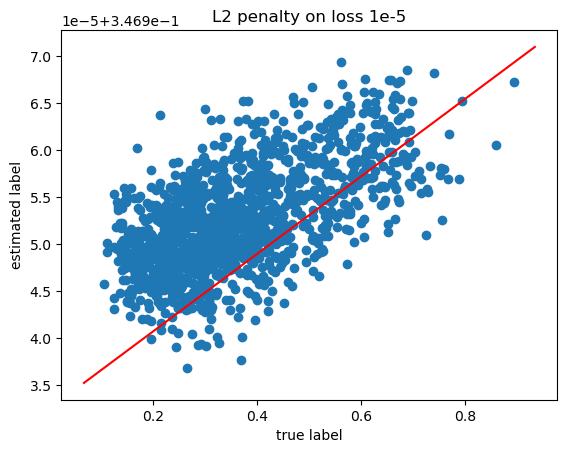

In [107]:
plt.scatter(truth_L2, est_L2)
xline = plt.xlim()
yline = plt.ylim()
plt.plot(xline, yline, color = 'r')
plt.xlabel("true label")
plt.ylabel("estimated label")
plt.title("L2 penalty on loss 1e-5")

In [18]:
λ = 1e-3
lr = 1e-4
train_loader, val_loader, test_set = split_data(ds, batch_size=32)
model = Pnet(HP)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=λ )
# cost_fn = torch.nn.MSELoss()
cost_fn = torch.nn.MSELoss()
history_L2 = train(model, train_loader, val_loader, optimizer, cost_fn, 100, 32)
plot_metrics(history_L2)
est_L2 = list()
truth_L2 = list()
for point, label in test_set:
    ŷ = model(point)
    est_L2.append(ŷ.detach().numpy())
    truth_L2.append(label)
r2 = get_r2(truth_L2, est_L2)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1386 and 11983x32)

In [67]:
r2

Text(0.5, 1.0, 'L2 penalty loss λ=0.001 and lr=0.0001')

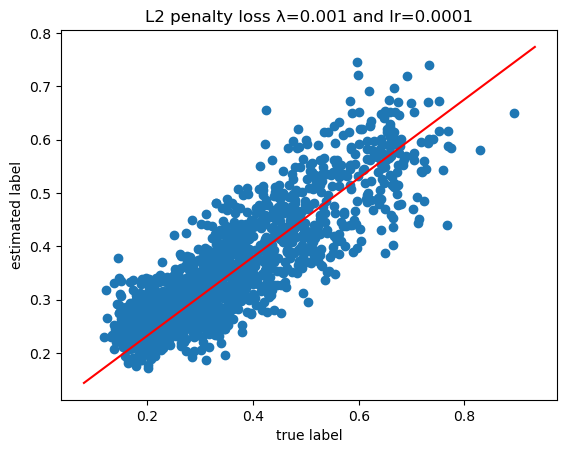

In [20]:
plt.scatter(truth_L2, est_L2)
xline = plt.xlim()
yline = plt.ylim()
plt.plot(xline, yline, color = 'r')
plt.xlabel("true label")
plt.ylabel("estimated label")
plt.title(f"L2 penalty loss λ={λ} and lr={lr}")

# Which Neurons in visual cortex contain the most information about pupil area?
# Compute the decoding accuracy from neurons at different cortical depths


In [8]:
# first we create a dataset object of the raw data
from torch.utils.data import Dataset
class LayerDataset(Dataset):
    def __init__(self, data_path, label_path, *, subset:int = -1, transform:bool=True):
        super(LayerDataset, self).__init__()
        self._load_(data_path, label_path, subset, transform)


    def __getitem__(self, item):
        return self.X[item], self.Y[item]

    def __len__(self):
        return len(self.X)

    def _load_(self, dpath, lpath, subset, transform):
        self.data = np.load(dpath, allow_pickle=True)
        self.label = np.load(lpath, allow_pickle=True).item()

        if  transform:
            self.data -= self.data.mean(axis=1)[:,np.newaxis]
            self.data /= self.data.var(axis=1)[:,np.newaxis]
            self.label['pupilArea'] /= self.label['pupilArea'].max(axis=0)

        if subset == -1:
            self.X = torch.from_numpy(self.data).T
            self.Y = torch.from_numpy(self.label['pupilArea'])
            del self.data
        else:
            self.X = torch.from_numpy(self.data[:,subset]).T
            self.Y = torch.from_numpy(self.label['pupilArea'][:subset])
            del self.data


def split_data(ds, split=[0.6,0.2, 0.2], batch_size=32):
    if len(split) == 2:
        train_split, val_split = torch.utils.data.random_split(ds, lengths= split)
        trainloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size)
        valloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
        return trainloader, valloader

    else:
        train_split, val_split, test_split = torch.utils.data.random_split(ds, lengths= split)
        trainloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size)
        valloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
        return trainloader, valloader, test_split



ds = LayerDataset("layer1.npy",'stringer_spontaneous.npy')
for batch in ds:
    x, y = batch
    break

print(x.shape, x)
print(y.shape, y)

torch.Size([1386]) tensor([-0.0544, -0.0307, -0.0764,  ...,  0.0435, -0.0159, -0.1605],
       dtype=torch.float64)
torch.Size([1]) tensor([0.3306], dtype=torch.float64)


In [26]:
def full_run(data:str):
    tmp= np.load(data)
    HP = { 'fc1_in': tmp.shape[0],
            'fc1_out':2**10 ,
            'fc2_out': 2**8,
            'fc3_out': 2**5,
            'fc4_out': 2**3,
            'fc5_out': 2**0,
           "lr": 1e-3}
    del tmp

    lambdas = [0, 1e-3]
    lr = 1e-4
    ds = LayerDataset(data, "stringer_spontaneous.npy")
    train_loader, val_loader, test_set = split_data(ds, batch_size=64)
    model = Pnet(HP)
    for λ in lambdas:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=λ)
        cost_fn = torch.nn.MSELoss(reduction="mean")
        history_L2 = train(model, train_loader, val_loader, optimizer, cost_fn, 100, 64)
        plot_metrics(history_L2)
        plot_r2(model, test_set, data, λ, lr)


In [25]:
full_run("layer1.npy")

Finished Training
Finished Training
Finished Training


In [27]:
for i in range(1,10):
    full_run(f"layer{i}.npy")

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop

/usr/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [11]:
from torch.utils.data import Dataset

class LayerFaceDataset(Dataset):
    def __init__(self, data_path, label_path, *, subset:int = -1, transform:bool=True):
        super(LayerFaceDataset, self).__init__()
        self._load_(data_path, label_path, subset, transform)


    def __getitem__(self, item):
        return self.X[item], self.Y[item]

    def __len__(self):
        return len(self.X)

    def _load_(self, dpath, lpath, subset, transform):
        self.label = np.load(lpath, allow_pickle=True)
        self.data = np.load(dpath, allow_pickle=True)[self.label>=0,...]
        self.label = self.label[self.label>=0]

        if  transform:
            self.data = self.data.reshape(self.data.shape[0], -1)
            self.data -= self.data.mean(axis=1)[:, np.newaxis]
            self.data /= self.data.var(axis=1)[:, np.newaxis]
            self.data = self.data.reshape(self.data.shape[0], 240,320)[:,np.newaxis,...]

        if subset == -1:
            self.X = torch.from_numpy(self.data)
            self.Y = torch.from_numpy(self.label).to(torch.long)
            del self.data
        else:
            self.X = torch.from_numpy(self.data[:,subset])
            self.Y = torch.from_numpy(self.label[:subset])
            del self.data

In [3]:
# dpath = "face_motion_all.npy"
# lpath = "labels_150Neighors.npy"
# ds = LayerFaceDataset(dpath,lpath)
# for data, label in ds:
#     print(label)
#     print(data)
#     plt.imshow(data.detach().numpy())
#     break


KeyboardInterrupt: 

In [10]:
def split_data(ds, split=[0.6,0.2, 0.2], batch_size=32):
    if len(split) == 2:
        train_split, val_split = torch.utils.data.random_split(ds, lengths= split)
        trainloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size)
        valloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
        return trainloader, valloader

    else:
        train_split, val_split, test_split = torch.utils.data.random_split(ds, lengths= split)
        trainloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size)
        valloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
        return trainloader, valloader, test_split

In [15]:
# Define network architecture. We'll try a simple FF network first.
HP = { '1c_in': 1,
        '1c_out':1 ,
        '1ks': 5,
        'stride': 2,
       "lr": 1e-3}

class PConvNet(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.conv = nn.Conv2d(hp['1c_in'], hp["1c_out"], kernel_size=hp['1ks'], stride=hp['stride'],  padding=hp['1ks']//2 )
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(4)
        self.convstack1 = nn.Sequential(self.conv, self.act, self.pool)
        # self.convstack2 = nn.Sequential(nn.Conv2d(16, 1, 5, 1,2), self.act, self.pool)
        self.flatten = nn.Flatten()
        self.classifer = nn.Sequential(self.flatten, nn.Linear(1200,1))

    def forward(self, x):
        if x.ndim == 1:
            self.convstack1(x)
            return self.convstack2(x)
        else:
            # x = x.view( 240, 320)
            x = self.convstack1(x)
            # x =  self.convstack2(x)
            x = self.flatten(x)
            return self.classifer(x).squeeze()

model = PConvNet(HP)
optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'])
test = torch.rand((64, 1, 240, 320))
model(test).shape

torch.Size([64])

In [16]:
def full_run():
    HP = { '1c_in': 1,
        '1c_out':1 ,
        '1ks': 5,
        'stride': 2,
       "lr": 1e-3}

    dpath = "face_motion_all.npy"
    lpath = "labels_150Neighors.npy"

    lr = 1e-4
    ds = LayerFaceDataset(dpath, lpath)
    train_loader, val_loader, test_set = split_data(ds, batch_size=64)
    model = PConvNet(HP)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cost_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    history_L2 = train(model, train_loader, val_loader, optimizer, cost_fn, 10, 64)
    plot_metrics(history_L2)
    # plot_r2(model, test_set, data, λ, lr)


In [17]:
full_run()

IndexError: Target 4 is out of bounds.